In [11]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from keras.utils import np_utils
from tensorflow.keras.layers import Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers, optimizers
import tensorflow as tf
from tensorflow.keras.applications import ResNet50,VGG16,ResNet101, VGG19, DenseNet201, EfficientNetB4, MobileNetV2
from tensorflow.keras.applications import resnet, vgg16 , vgg19, densenet, efficientnet, mobilenet_v2
from tensorflow.keras import Model

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import PIL
import os
import cv2

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
path = "/content/drive/MyDrive/Dataset/Data"
for files in os.listdir(path):
    print(os.path.join(path,files))

/content/drive/MyDrive/Dataset/Data/valid
/content/drive/MyDrive/Dataset/Data/test
/content/drive/MyDrive/Dataset/Data/train


In [14]:
train_path = "/content/drive/MyDrive/Dataset/Data/train"
valid_path = "/content/drive/MyDrive/Dataset/Data/valid"
test_path = "/content/drive/MyDrive/Dataset/Data/test"

In [15]:
image_paths = ['/content/drive/MyDrive/Dataset/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa',
'/content/drive/MyDrive/Dataset/Data/train/normal',
'/content/drive/MyDrive/Dataset/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
'/content/drive/MyDrive/Dataset/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib']

def load_images(image_paths = image_paths, n=36):
    # Load the images from disk.
    images = []
    for i in range(len(image_paths)):
        images_ = [cv2.imread(image_paths[i]+'/'+path) for path in os.listdir(image_paths[i])[:int(n/4)]]
        images.append(images_)
    # Convert to a numpy array and return it.
    sample = np.asarray(images)
    return sample

<ipython-input-15-4ece2c6f339c>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample = np.asarray(images)


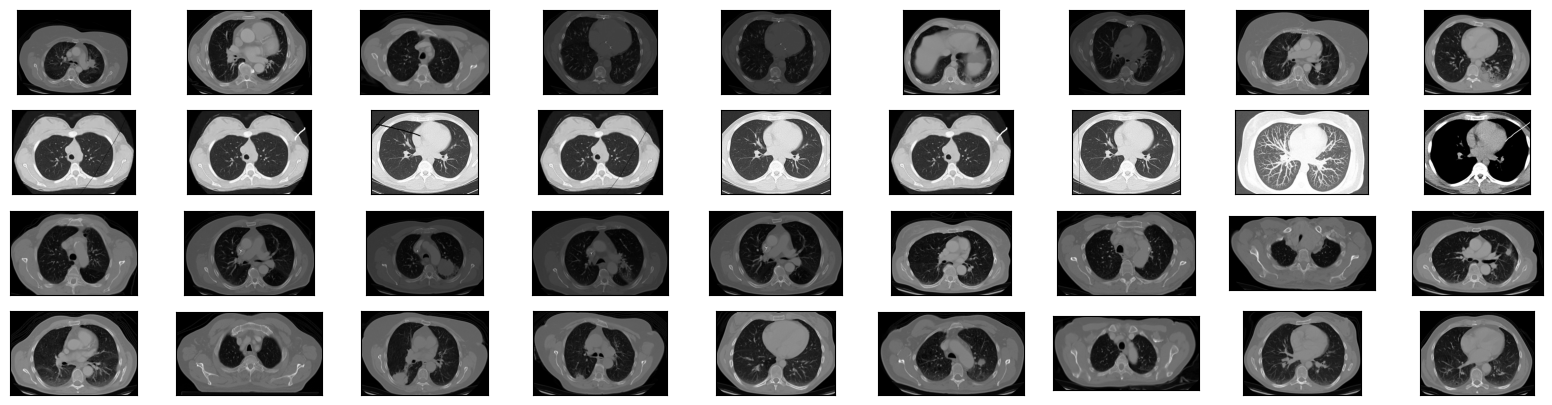

In [16]:
sample = load_images()
fig = plt.figure(figsize=(20,5))
l = 1
shapes = []
for i in range(sample.shape[0]):
    for m in range(sample.shape[1]):
        ax = fig.add_subplot(4,9,m+l,xticks = [], yticks = [])
        ax.imshow(np.squeeze(sample[i,m]))
        shapes.append(sample[i,m].shape)
    l +=9

In [17]:
np.array(shapes).mean(axis=0)

array([280.33333333, 413.02777778,   3.        ])

# ** IMAGE PREPROCESSING**

In [18]:
label_dirs = ['train', 'test', 'valid']

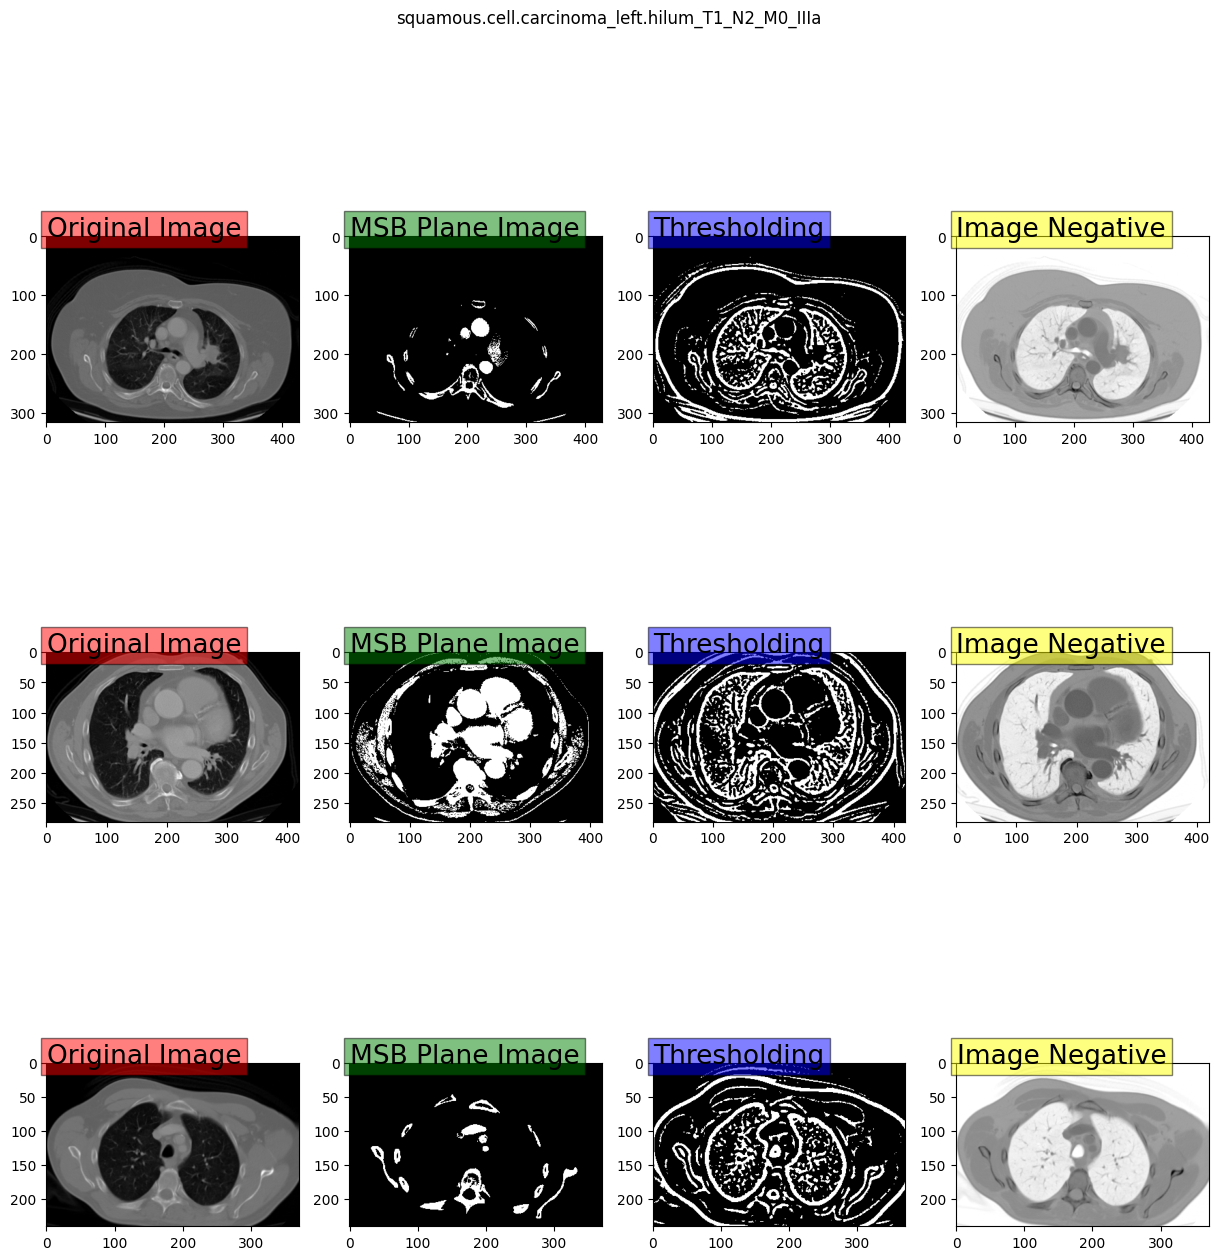

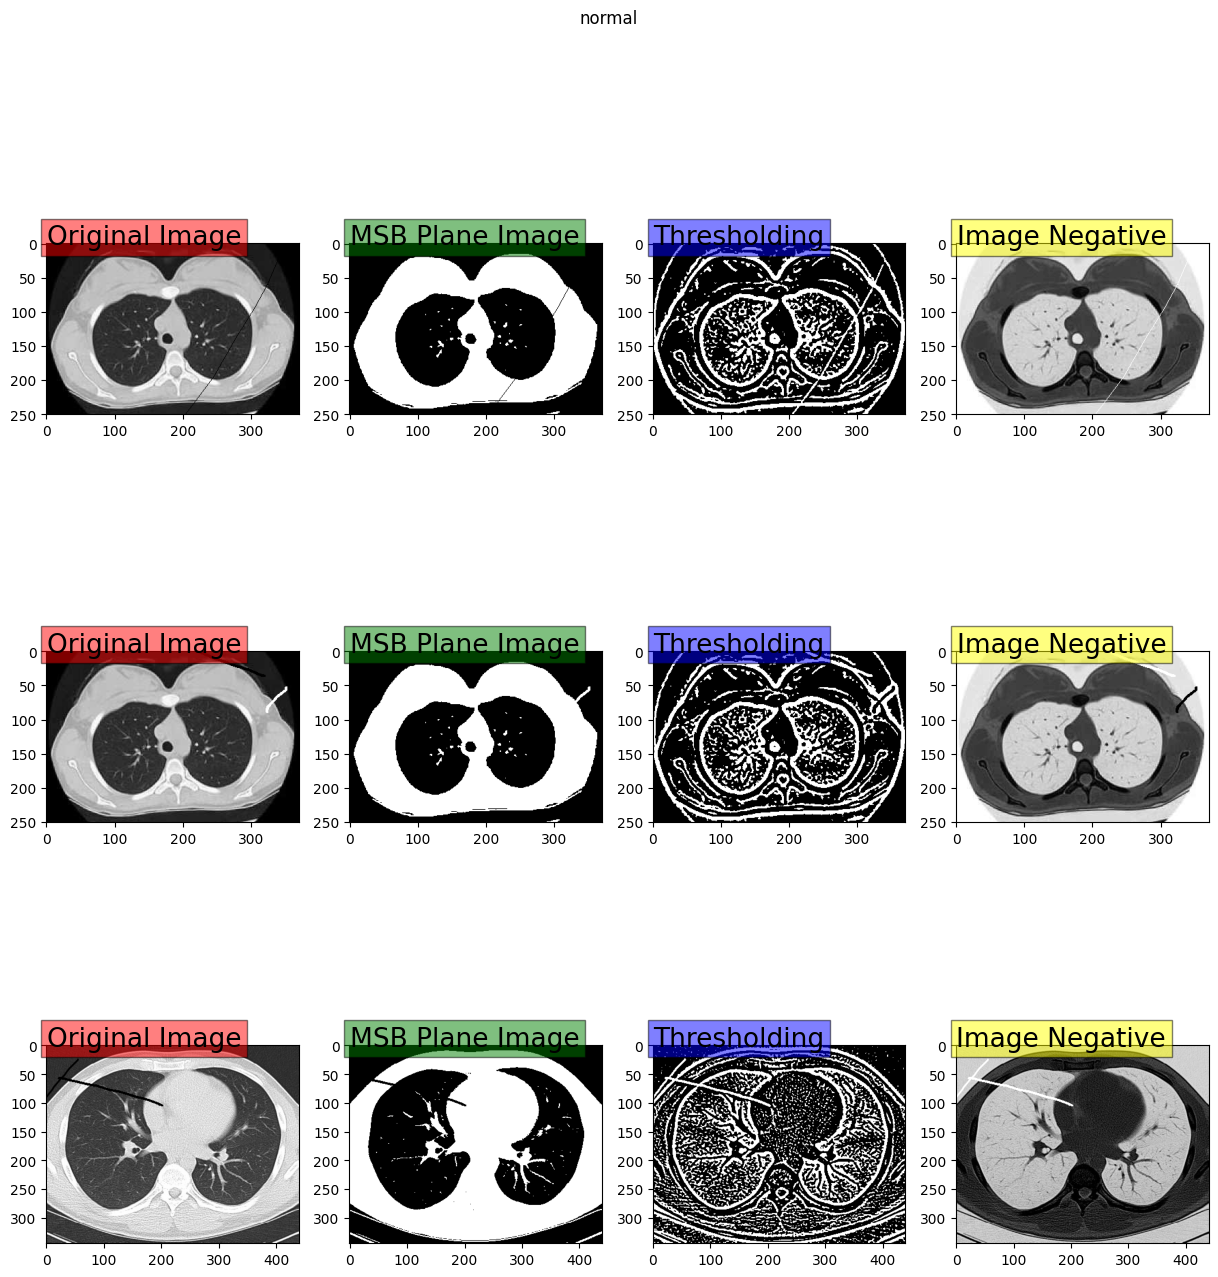

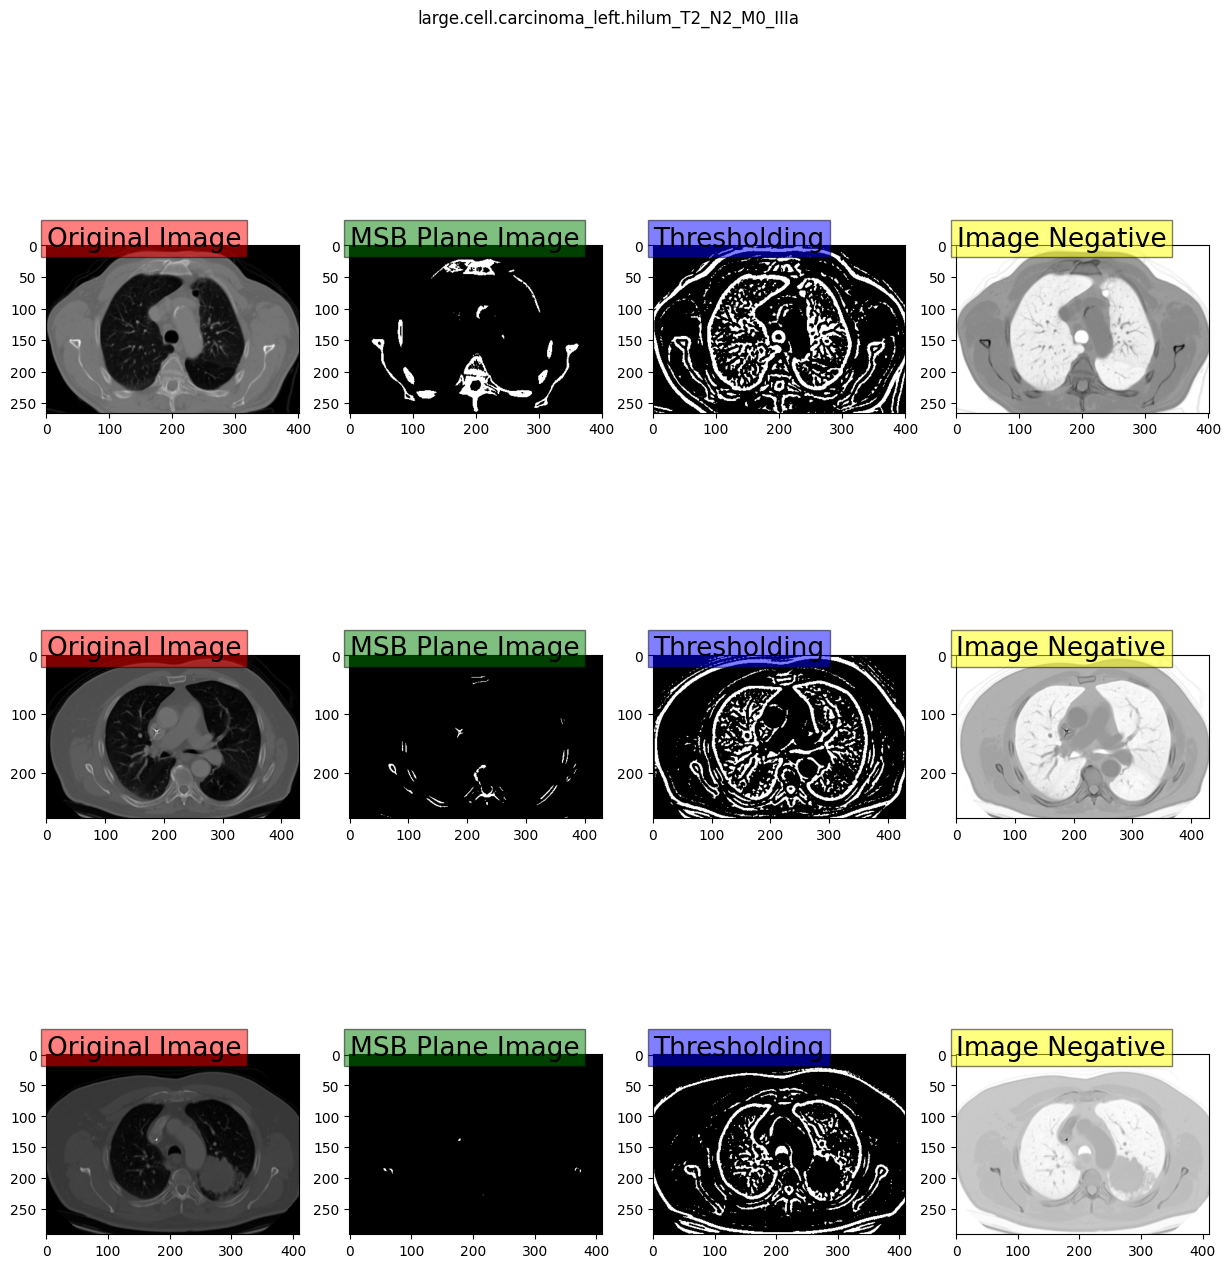

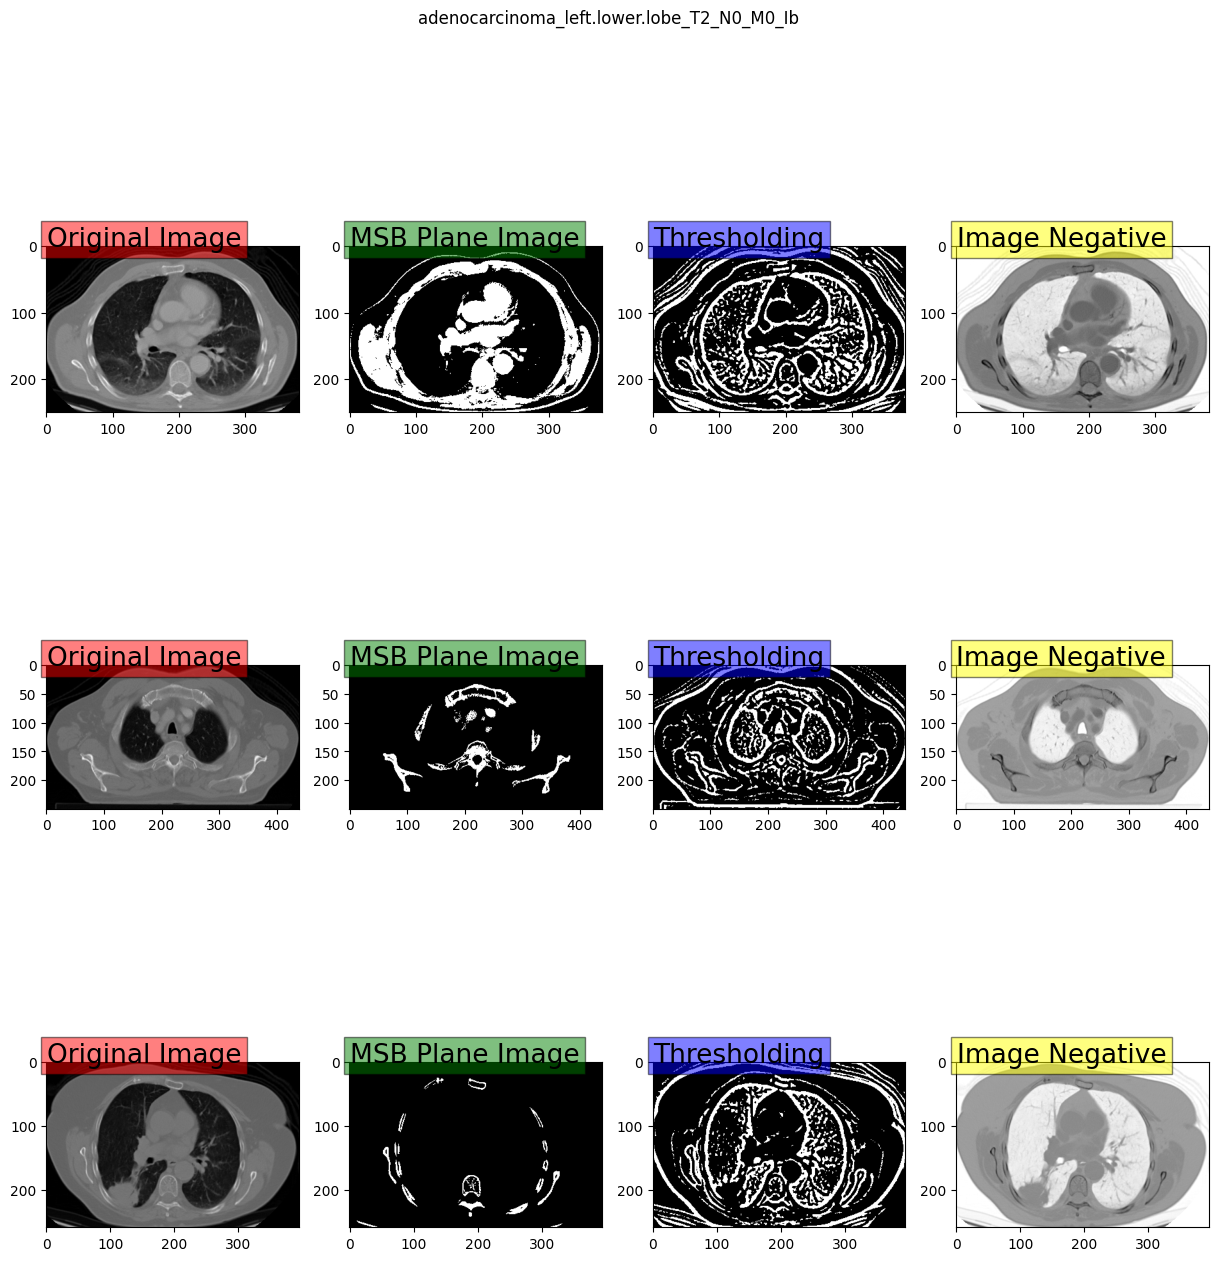

In [20]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Function to apply image processing techniques
def apply_image_processing(image):
    # Apply Gaussian Blur
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply Adaptive Thresholding
    adaptive_threshold = cv2.adaptiveThreshold(
        blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 2
    )

    # Image Negative
    negative_image = 255 - adaptive_threshold

    return negative_image

# Loop through each image path
for image_path in image_paths:
    class_name = os.path.basename(image_path)

    # Take 3 samples from each class to be processed
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 4, figsize=(15, 15))
    fig.suptitle(class_name)

    for curr_cnt, filename in enumerate(os.listdir(image_path)):
        image_file_path = os.path.join(image_path, filename)
        img = cv2.imread(image_file_path)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Resizing images with the target image size
        img0 = cv2.resize(img, (224, 224))

        # Apply Gaussian Blur to smooth the image
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Apply Adaptive thresholding
        thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 4)
        thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 3)

        # Apply Bit Plane Slicing
        lst = []
        for i in range(gray.shape[0]):
            for j in range(gray.shape[1]):
                lst.append(np.binary_repr(gray[i][j], width=8)) # width = no. of bits
        eight_bit_img = (np.array([int(i[0]) for i in lst], dtype=np.uint8) * 128).reshape(gray.shape[0], gray.shape[1])

        # Apply Image Negative
        invert = cv2.bitwise_not(gray)

        # Display images
        ax[cnt, 0].text(0.5, 0.5, 'Original Image', fontsize=19, bbox=dict(facecolor='red', alpha=0.5))
        ax[cnt, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[cnt, 1].text(0.5, 0.5, 'MSB Plane Image', fontsize=19, bbox=dict(facecolor='green', alpha=0.5))
        ax[cnt, 1].imshow(eight_bit_img, cmap='gray')
        ax[cnt, 2].text(0.5, 0.5, 'Thresholding', fontsize=19, bbox=dict(facecolor='blue', alpha=0.5))
        ax[cnt, 2].imshow(thresh, cmap='gray')
        ax[cnt, 3].text(0.5, 0.5, 'Image Negative', fontsize=19, bbox=dict(facecolor='yellow', alpha=0.5))
        ax[cnt, 3].imshow(invert, cmap='gray')
        cnt += 1

        if cnt == samples:
            break

    plt.show()


In [21]:
image_shape = (224,224,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (224,224),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (224,224),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', rescale = 1.0/255.0)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (224,224),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [ ]:
base_hidden_units = 8
weight_decay = 1e-3
model = Sequential([

    Conv2D(filters = 8 , kernel_size = 2, padding = 'same', activation = 'relu', input_shape = image_shape),
    MaxPooling2D(pool_size = 2),

    Conv2D(filters = 16 , kernel_size = 2, padding = 'same', activation = 'relu',
           kernel_regularizer = regularizers.l2(weight_decay)),
    MaxPooling2D(pool_size = 2),

    #Conv2D(filters = 64 , kernel_size = 2, padding = 'same', activation = 'relu',
     #     kernel_regularizer = regularizers.l2(weight_decay)),
    #MaxPooling2D(pool_size = 2),

    Dropout(0.4),
    Flatten(),
    Dense(300,activation='relu'),
    Dropout(0.5),
    Dense(4,activation='softmax')

])

model.summary()

# **# TRAIN THE MODEL**

In [ ]:
# Define callbacks
checkpointer = ModelCheckpoint('chestmodel.hdf5', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

# Define optimizer with learning rate
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate= 0.00001, decay= 1e-6)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch=20,
    epochs=100,
    verbose=1,
    validation_data=valid_generator,
    callbacks=[checkpointer, early_stopping]
)


In [ ]:
result = model.evaluate(test_generator)

In [ ]:
plt.plot(history.history['acc'], label = 'train',)
plt.plot(history.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# **TRANSFER LEARNING**

**RESNET50**

In [ ]:
image_shape = (224,224,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=resnet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (224,224),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=resnet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (224,224),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=resnet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (224,224),
                                                   class_mode = 'categorical')

In [ ]:
res_model = ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in res_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False
# Check if all layers except conv5 layers are not trainable
#for i, layer in enumerate(res_model.layers):
#    print(i, layer.name, "-", layer.trainable)

In [ ]:
model = Sequential()
model.add(res_model)
model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate= 0.00001, decay= 1e-6)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-ResNet50.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [ ]:
history_res = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

In [ ]:
result = model.evaluate(test_generator)

# **DenseNet201**

In [ ]:
image_shape = (224,224,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (224,224),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (224,224),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (224,224),
                                                   class_mode = 'categorical')

In [ ]:
dense_model = DenseNet201(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in dense_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False
# Check if all layers except conv5 layers are not trainable
#for i, layer in enumerate(dense_model.layers):
#    print(i, layer.name, "-", layer.trainable)

In [ ]:
model = Sequential()
model.add(dense_model)
#model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
#model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate= 0.00001, decay= 1e-6)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-DenseNet201.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [ ]:
history_dense = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

In [ ]:
result = model.evaluate(test_generator)